# Stochastic Simulation Algorithm - il metodo di Gillespie (-Doob)

Questo algoritmo simula un processo governato da una master equation con metodi montecarlo.
È composto dai seguenti 4 step:

>* **Inizializzazione:** imposta il valore iniziale di ogni tipo di molecola, 
quali sono le reazioni e le costanti di reazione
* **Monte Carlo:** decido quale reazione far avvenire, e quanto tempo trascorra prima che quasta avvenga.
In base alle reazione ottengo la modifica da fare al mio sistema
* **Aggiorno:** Sommo le modifiche allo stato del mio sistema e aggiungo il tempo trascorso
* **Ripeto:** dal passaggio 2 finchè non raggiungo una certa condizione (tipicamente che sia
trascorso un certo tempo).

Posso poi ripetere più volte questa simulazione per avere un'idea di come variano nel tempo le mie sostanze.

![Gillespie Trajectories](http://www.theosysbio.bio.ic.ac.uk/wp-content/uploads/2011/07/example3a.png)

## Dettagli dell'algoritmo

siano $\lambda_i(s)$ le affinità di reazione di tutte le reazioni possibili nel sistema 
(che dipendono dallo stato del sistema, ma non dal tempo), e $\delta_i$ le modifiche che queste
provocheranno nel sistema (che sono invece indipendenti sia dallo stato del sistema che dal tempo).

Ogni reazione ha una probabilità costante di avvenire in ogni intervallo di tempo, quindi la probabilità che 
in un certo intervallo **t** nello stato **s** non avvenga la reazione **i** è 

### $ p_i(s,t)=e^{-\lambda_i(s)t}$

ne consegue che il tempo di attesa prima che avvenga una qualsiasi reazione 
dipende dalla somma di tutte le costanti cinetiche:

### $p(s,t)=e^{-\sum_i \lambda_i(s)t}$

Rimane ora da decidere quale di queste reazioni sia avvenuta. 
Sappiamo che nel tempo indicato una reazione è avvenuta (per definizione), quindi dobbiamo estrarre a sorte quale
sia effettivamente avvenuta.

Con un pò di calcoli si può far vedere che la probabilità di estrazione di ogni singola reazione è pari
al rapporto fra la sua affinità cinetica $\lambda_i(s)$ rispetto alla affinità cinetica totale $\lambda$,
ovvero:

### $p_i = \frac{\lambda_i(s)}{\sum_i \lambda_i(s)}$

## Reazioni di interconversione

Per testare se il metodo funziona effettivamente effettuo le mie simulazioni su di un sistema di cui conosco il più possibile, in modo da poter
controllare se i risultati ottenuti dal modello sono compatibili con quelli esatti.

Come modello di riferimento scegliamo la reazione di interconversione, in cui abbiamo un numero N di molecole che possono trovarsi in uno fra due possibili stati
che chiameremo A e B. Il passaggio da uno stato all'altro avviene con probabilità costante nel tempo per ogni singola molecola, e quindi si comporta come un 
decadimento esponenziale per un numero finito di molecole, per cui la costante di reazione per il passaggio da A a B è pari al prodotto della quantità
di molecole che si trovano nello stato A per una costante cinetica $k_a$.

la distribuzione stazionaria è una binomiale:
### $P_{nA}^s = \binom {nA} {N} (\frac{k_a}{k_a + k_b})^{nA} (\frac{k_b}{k_a + k_b})^{nB}$

la cui media risulta essere:
### $ \langle{nA}\rangle = N \frac{k_a}{k_a + k_b}$

il tempo caratteristico di rilassamento allo stato stazionario è dato dall'inverso dell'autovalore dell'autostato metastabile ed è pari a:
### $\tau_c = \frac{1}{k_a + k_b} $

## Definizione dello stato del sistema
Creo uno stato definito da due stati, A e B.

Lo rappresento con una classe che chiamo **Stato**, che contiene la descrizione dello stato che osservo (quante
molecole di ciascuna specie, gli elementi **A** e **B**), quando ho iniziato ad osservare quello stato 
(l'elemento chiamato **t**) e per quanto tempo questo è rimasto prima che una reazione avvenisse (l'elemento **dt**)

In [1]:
%matplotlib inline
from pylab import *
from collections import namedtuple

In [2]:
class Stato(namedtuple('Stato',"A, B, dt, t")):
    def __add__(self, s2): 
        """sommo gli stati"""
        return Stato(self.A+s2.A,
                     self.B+s2.B,
                     self.dt+s2.dt,
                     self.t+s2.t)

In [3]:
a = Stato(1, 2, 0, 0)
a

Stato(A=1, B=2, dt=0, t=0)

In [4]:
b = Stato(-1, 0, 0, 0)
a = a._replace(A=3)
a, b

(Stato(A=3, B=2, dt=0, t=0), Stato(A=-1, B=0, dt=0, t=0))

In [5]:
print a + b

Stato(A=2, B=2, dt=0, t=0)


## La definizione delle reazioni del mio sistema

Posso avere due reazioni diverse:

* A che diventa B
* B che diventa A

ciascuna riduce di uno uno stato ed aumenta di uno l'altro.

ciascuna sarà caratterizzata da uno stato che mi determina la variazione di ciascuna molecola, ed una funzione che dato lo stato attuale mi restituirà la rate di ciascuna reazione

In [6]:
mod_R1 = Stato(-1,1,0,0)
mod_R2 = Stato(1,-1,0,0)

k_R1 = lambda s: s.A * 0.1
k_R2 = lambda s: s.B * 0.1

controlliamo che ci dia il risultato che ci attendiamo per la lambda totale (tempo prima che avvenga una reazione)

In [7]:
attuale = Stato(55,45,0,0)
attuale

Stato(A=55, B=45, dt=0, t=0)

In [8]:
lambda_tot = k_R1(attuale)+k_R2(attuale)
print lambda_tot

10.0


Qui simuliamo l'estrazione a sorte: se il numero casuale è inferiore al 
rapporto fra la prima affinità di reazione e quella totale, avviene la prima reazione, altrimenti avviene la seconda.

In [9]:
if rand()<k_R1(attuale)/lambda_tot:
    step = mod_R1
else:
    step = mod_R2
print step

Stato(A=1, B=-1, dt=0, t=0)


Ora estraggo il tempo di soggiorno. Come da definizione il tempo in cui permango nello stato è distribuito esponenzialmente.
Per poter modificare il mio stato lo posso direttamente sommare

In [10]:
from numpy.random import exponential as rand_exp

delta_t = rand_exp(1./lambda_tot)
step = Stato(step.A,step.B, delta_t,0)
print step

Stato(A=1, B=-1, dt=0.06592304264031777, t=0)


## La funzione di avanzamento

Questa funzione è il vero cuore della simulazione. È composta di due parti principali:

* estrae la reazione che avviene e ne ottiene le relative modifiche
* estrae il tempo di permanenza dello stato attuale
* crea il nuovo stato e ritorna entrambi (vedremo fra poco perchè)

In [11]:
def step(stato):
    lambda_tot = k_R1(stato)+k_R2(stato)
    
    if rand()<k_R1(stato)/lambda_tot:
        delta_s = mod_R1
    else:
        delta_s = mod_R2
    
    dt =  rand_exp(1./lambda_tot)
    
    stato = stato._replace(dt=dt)
    delta_s = delta_s._replace(t=dt)
    new_stato = stato + delta_s
    
    return stato,new_stato

print step(attuale)

(Stato(A=55, B=45, dt=0.016845236391675247, t=0), Stato(A=54, B=46, dt=0.016845236391675247, t=0.016845236391675247))


## La nostra prima simulazione

In [12]:

def run(old_s,t_end):
    while old_s.t < t_end:
        old_s,new_s = step(old_s)
        yield old_s
        old_s = new_s
        

In [13]:
old_s = Stato(100,0,0,0)

for stato in run(old_s, 1.0):
    print stato.A, stato.t

100 0
99 0.205175795933
98 0.370476520911
97 0.384994943867
96 0.402552270613
95 0.458374474755
94 0.487238890557
93 0.490138879189
92 0.560612192819
91 0.581798951058
90 0.736434551564
89 0.797567068583
88 0.855326515808
87 0.919920893838


In [14]:
t_max = 200.
passaggi=[ i for i in run(old_s,t_max) ]

A,B,delta_t,tempo = zip(*passaggi)

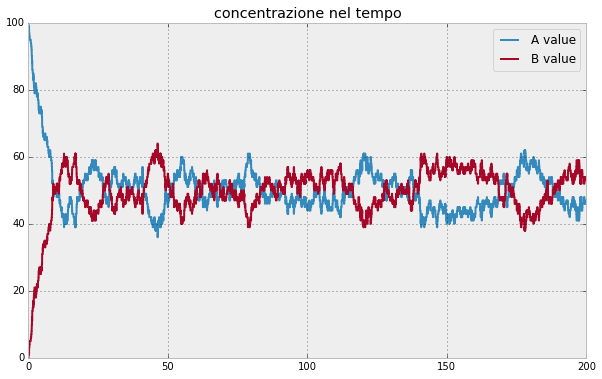

In [15]:
total_t=delta_t[-1]+tempo[-1]

from matplotlib.pyplot import step as step_plot
fig = figure(figsize=(10,6))
#plot(tempo,A,'b',tempo,B,'r',linestyle='steps');
step_plot(tempo, A, where='post', label='A value')
step_plot(tempo, B, where='post', label='B value')
legend();
ylim(0,100)
title("concentrazione nel tempo");

## Statistica dei risultati

In [17]:
from collections import Counter
distribuzione = Counter()
osservazioni = Counter()

for A,B,dt,t in passaggi:
    if t>20:
        distribuzione[A]+=dt
        osservazioni[A]+=1

for s,p in sorted(distribuzione.items()):
    print s,p

36 0.055099526472
37 0.0638280808394
38 0.207421808282
39 1.24491789075
40 2.22364878766
41 3.92209206366
42 5.98932889291
43 5.98264634367
44 9.13365079428
45 9.17589181088
46 13.0547094324
47 12.8401012991
48 12.4249845687
49 14.8147409971
50 13.2315459271
51 11.3191981486
52 13.3330038485
53 10.3699582935
54 10.1097038747
55 8.83696731805
56 6.43168625039
57 4.69995647614
58 4.08810601091
59 3.63793407823
60 1.64259190805
61 0.931557831714
62 0.142587172408


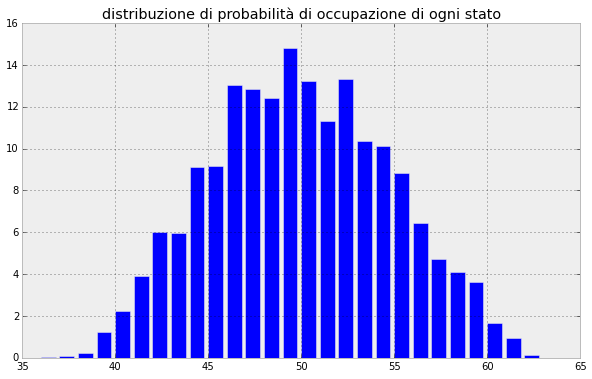

In [18]:
fig = figure(figsize=(10,6))
bar(distribuzione.keys(), distribuzione.values())
title(u"distribuzione di probabilità di occupazione di ogni stato");

##Simulazioni multiple##

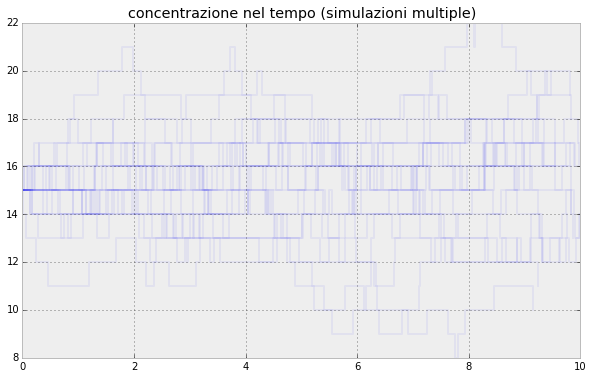

In [19]:
fig = figure(figsize=(10,6))

t_max = 10.
for i in range(20):
    old_s = Stato(15,15,0,0)
    passaggi=[ i for i in run(old_s,t_max) ]
    A,B,delta_t,tempo = zip(*passaggi)
    step_plot(tempo, A, where='post',
              color='blue',alpha=0.05)
    #step_plot(tempo, B, where='post',color='red',alpha=0.3)
title("concentrazione nel tempo (simulazioni multiple)");

## Confronto fra diverse dimensioni del campione

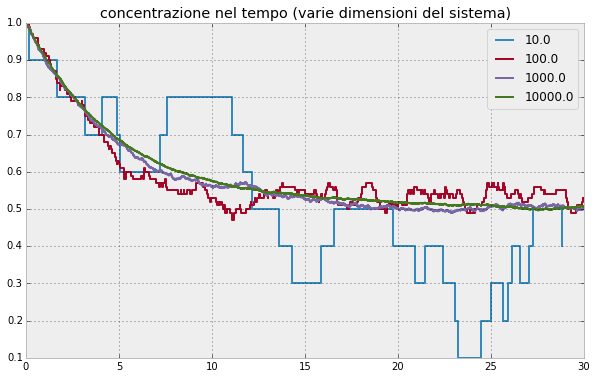

In [20]:
fig = figure(figsize=(10,6))

t_max = 30.
for N in [10., 100., 1000., 10000.]:
    old_s = Stato(N,0,0,0)
    passaggi=[ i for i in run(old_s,t_max) ]
    A,B,delta_t,tempo = zip(*passaggi)
    norm_A = [ i/N for i in A ]
    step_plot(tempo, norm_A, where='post',label=str(N))
    #step_plot(tempo, B, where='post',color='red',alpha=0.3)
legend();
title("concentrazione nel tempo (varie dimensioni del sistema)");

## Miglioriamo la statistica

 tempo caratteristico del sistema =  0.818730753078
 intervallo di tempo da rimuovere =  8.18730753078
            tempo totale simulato =  100000.0
 tempo di residenza medio stimato =  0.100010644364
tempo di residenza medio previsto =  0.1
        step compiuti dal sistema =  999812


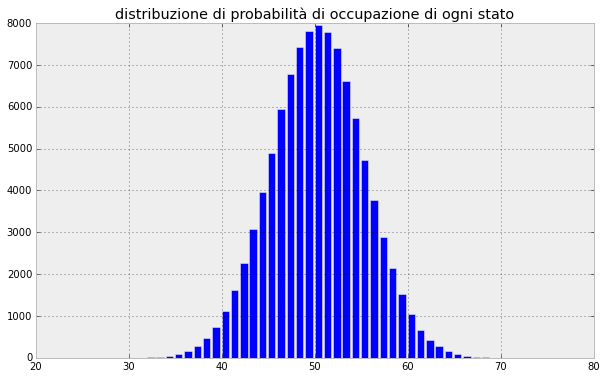

In [21]:
fig = figure(figsize=(10,6))

N = 100

metastabile = 0.1 + 0.1
tempo_caratteristico = exp(-metastabile)
t_minimo = 10 * tempo_caratteristico
equilibrio = Stato(N/2,N/2,0,0)
lambda_tot_stabile = k_R1(equilibrio)+k_R2(equilibrio)
t_max = 100000.

old_s = Stato(N,0,0,0)

def run(old_s,t_end):
    while old_s.t < t_end:
        old_s,new_s = step(old_s)
        yield old_s
        old_s = new_s

passaggi=[ i for i in run(old_s,t_max) if i.t>t_minimo]

A,B,delta_t,tempo = zip(*passaggi)

total_t=delta_t[-1]+tempo[-1]

print " tempo caratteristico del sistema = ",tempo_caratteristico
print " intervallo di tempo da rimuovere = ",t_minimo
print "            tempo totale simulato = ",t_max
print " tempo di residenza medio stimato = ",mean(delta_t)
print "tempo di residenza medio previsto = ",1./lambda_tot_stabile
print "        step compiuti dal sistema = ",len(delta_t)

distribuzione = Counter()

for A,B,dt,t in passaggi:
    distribuzione[A]+=dt
    
bar(*zip(*distribuzione.items()));
title(u"distribuzione di probabilità di occupazione di ogni stato");
#figure()
#hist(delta_t,bins=100);

## Reazioni multiple

Cosa succederebbe se avessimo reazioni multiple? il confronto non sarebbe più semplice come prima, ma neppure
eccessivamente complesso.

Inizio ridefinendo le mie reazioni. Ora ne avrà 4. due di interconversione fra A e B e due di creazione/distruzione sulla A.

In [22]:
k_R1 = lambda s: s.A
mod_R1 = Stato(-1,1,0,0)

k_R2 = lambda s: s.B
mod_R2 = Stato(1,-1,0,0)

k_R3 = lambda s: 10.0
mod_R3 = Stato(1,0,0,0)

k_R4 = lambda s: 0.1*s.A
mod_R4 = Stato(-1,0,0,0)

cinetiche = [   k_R1,   k_R2,   k_R3,   k_R4 ]
modifiche = [ mod_R1, mod_R2, mod_R3, mod_R4 ]

Ora modifico la mia modalità di scelta.
Creo il vettore con i risultati delle 4 funzioni, ne sommo il totale e divido tutte per quel valore.
Questo mi darebbe le probabilità per ciascuna reazione.

Per l'estrazione è più comodo fare la somma progressiva in modo da poter fare una sola ricerca nel vettore.

L'indice che ottengo da questa ricerca mi indica quale reazione avviene, 
permettendomi di scegliere quale sia la modifica da applicare

In [23]:
sto = Stato(50,50,0,0)
kin = add.accumulate([ f(sto) for f in cinetiche ])
kin/= kin[-1]
print kin
p=rand()
idx = searchsorted(kin,p)
print p
print idx

[ 0.43478261  0.86956522  0.95652174  1.        ]
0.744326440515
1


Devo quindi ridefinire la funzione **step** di conseguenza, lasciando inaletrata la funzione di simulazione:

In [24]:
def step(stato):
    kin  = add.accumulate([ f(stato) for f in cinetiche ])
    lambda_tot = kin[-1]
    kin /= lambda_tot
    
    idx = searchsorted(kin,rand())
    delta_s = modifiche[idx]
    
    dt =  rand_exp(1./lambda_tot)
    stato = stato._replace(dt=dt)
    delta_s = delta_s._replace(t=dt)
    
    new_stato = stato + delta_s
    return stato,new_stato

def run(old_s,t_end):
    while old_s.t < t_end:
        old_s,new_s = step(old_s)
        yield old_s
        old_s = new_s

In [25]:
old_s = Stato(100,100,0,0)
t_minimo = 0. 
t_max = 100.

passaggi=[ i for i in run(old_s,t_max) if i.t>t_minimo]

A,B,delta_t,tempo = zip(*passaggi)

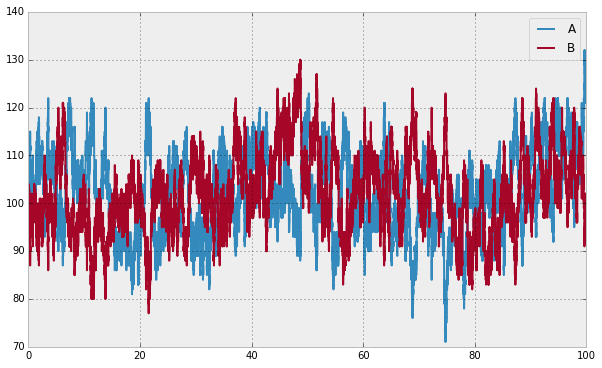

In [26]:
fig = figure(figsize=(10,6))

step_plot(tempo, A, where='post',label='A')
step_plot(tempo, B, where='post',label='B')
legend();

## Struttura dello spazio degli stati

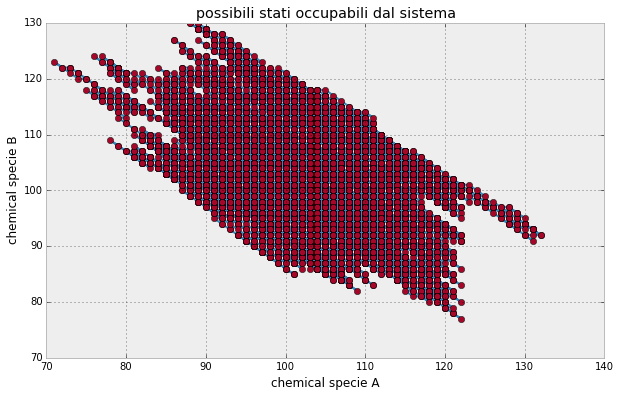

In [27]:
fig = figure(figsize=(10,6))

plot(A,B);
plot(A,B,'o');
xlabel('chemical specie A')
ylabel('chemical specie B');
title(u"possibili stati occupabili dal sistema");

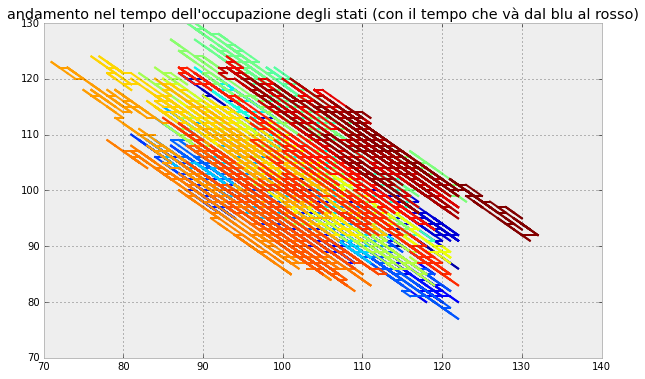

In [28]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,6))

L=len(A)
cm = plt.get_cmap('jet')
ax1.set_color_cycle([cm(1.*i/L) for i in range(L)])

A=array(A)
B=array(B)
for i in range(len(A)-1):
    plot(A[[i,i+1]],B[[i,i+1]]);
#plot(A,B,'o');
title(u"andamento nel tempo dell'occupazione degli stati (con il tempo che và dal blu al rosso)");

## Distribuzione in due dimensioni

ottenuta aumentanto la statistica (maggior tempo di osservazione)

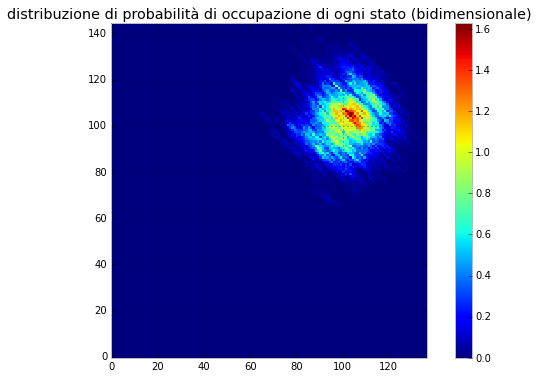

In [29]:
passaggi=[ i for i in run(old_s,1000) if i.t>200.]
distribuzione = Counter()

for a,b,dt,t in ((a,b,dt,t) for a,b,dt,t in passaggi if t>t_minimo):
    distribuzione[(a,b)]+=dt

A,B,delta_t,tempo = zip(*passaggi)    
    
immagine = zeros((max(A)+1,max(B)+1))
for (a,b),val in distribuzione.items():
    immagine[a,b]=val

fig = figure(figsize=(10,6))
imshow(immagine,origin='lower',interpolation='nearest');
colorbar()
title(u"distribuzione di probabilità di occupazione di ogni stato (bidimensionale)");

# distribuzione dei vari bin

visto che il tempo di occupazione è distribuito esponenzialmente e lo sommo N volte per ciascun bin, ho una stima diretta dell'incertezza perchè si comporta come una Gamma!

In [80]:
from __future__ import division
from numpy.random import exponential as rand_exp
from collections import Counter
import seaborn as sns

In [23]:
k_R1 = lambda s: 1.0*s.A
mod_R1 = Stato(-1,1,0,0)

k_R2 = lambda s: 1.0*s.B
mod_R2 = Stato(1,-1,0,0)


cinetiche = [   k_R1,   k_R2]
modifiche = [ mod_R1, mod_R2]

In [24]:
def step(stato):
    kin  = add.accumulate([ f(stato) for f in cinetiche ])
    lambda_tot = kin[-1]
    kin /= lambda_tot
    
    idx = searchsorted(kin,rand())
    delta_s = modifiche[idx]
    
    dt =  rand_exp(1./lambda_tot)
    stato = stato._replace(dt=dt)
    delta_s = delta_s._replace(t=dt)
    
    new_stato = stato + delta_s
    return stato,new_stato

def run(old_s,t_end):
    while old_s.t < t_end:
        old_s,new_s = step(old_s)
        yield old_s
        old_s = new_s

In [25]:
def distribution(stato, tmin, tmax):
    passaggi=[ i for i in run(stato, tmax) if i.t>tmin]
    A,B,delta_t,tempo = zip(*passaggi)
    distribuzione = Counter()
    conteggi = Counter()
    for a, b, dt, t in passaggi:
        distribuzione[a]+=dt
        conteggi[a]+=1
    return distribuzione, conteggi

In [108]:
old_s = Stato(10, 10, 0, 0)
t_minimo = 15. 
t_max = 20.
d, c = distribution(old_s, t_minimo, t_max)

In [235]:
d, c = zip(*[distribution(old_s, t_minimo, t_max) for i in range(200)])

In [236]:
d_100 = r_[[dist[10] for dist in d]]
c_100 = r_[[count[10] for count in c]]
t_100 = d_100/c_100


d_tot = r_[[sum(dist.values()) for dist in d]]
c_tot = r_[[sum(dist.values()) for dist in c]]

p_100 = d_100/d_tot

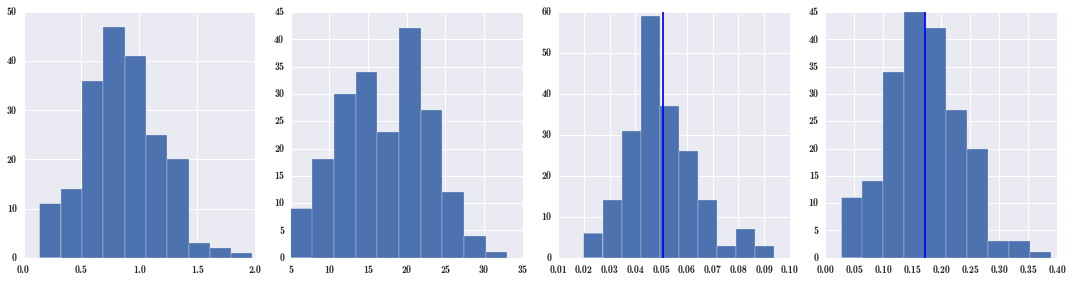

In [237]:
fig, ax = plt.subplots(1, 4, figsize = (15,4))
ax[0].hist(d_100)
ax[1].hist(c_100)
ax[2].hist(t_100)
ax[2].axvline(mean(t_100))
ax[3].hist(p_100)
ax[3].axvline(mean(p_100))
fig.tight_layout()

In [238]:
d_100[0], c_100[0], p_100[0]

(0.70200242531176738, 17, 0.140802514344123)

In [239]:
from scipy.stats import invgamma

In [240]:
len(p_100)

200

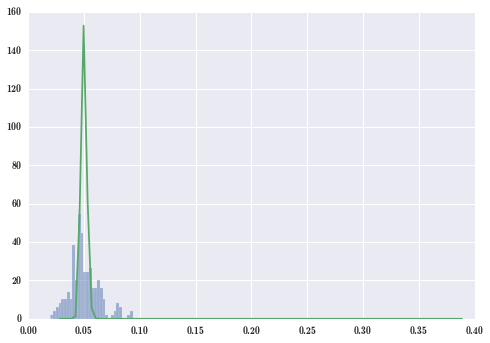

In [247]:
x = r_[min(p_100):max(p_100):100j]
G = invgamma(mean(c0), scale=mean(d0)).pdf(x)
_ = hist(t_100, normed=True, alpha=0.5, bins=30)
_ = plot(x, G)

In [248]:
import pymc

In [249]:
osservazioni_totali = c_tot[0]
osservazioni = c_100[0]
tempo = d_100[0]
tempo_totale = d_tot[0]

In [250]:
print osservazioni, osservazioni_totali, tempo, tempo_totale, tempo/osservazioni, tempo/tempo_totale

17 102 0.702002425312 4.98572364692 0.0412942603125 0.140802514344


(array([  25.,   75.,  181.,  240.,  187.,  151.,   75.,   35.,   18.,   13.]),
 array([ 0.3774299 ,  0.4928419 ,  0.60825391,  0.72366592,  0.83907793,
         0.95448993,  1.06990194,  1.18531395,  1.30072596,  1.41613796,
         1.53154997]),
 <a list of 10 Patch objects>)

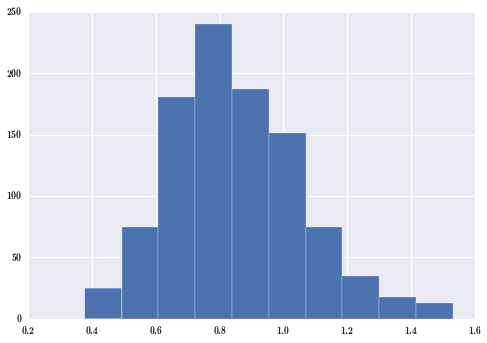

In [251]:
G = pymc.Gamma('tempi', alpha=osservazioni, beta=1/0.05)
hist([G.random() for i in xrange(1000)])

In [252]:
p_occupazione = pymc.Beta('p', 1.0, 1.0, value=tempo/tempo_totale)
t_occupazione = pymc.Gamma('t', 0.01, 0.01, value=tempo/osservazioni)
eventi = pymc.Binomial('eventi', n=osservazioni_totali, p=p_occupazione, observed=True, value=osservazioni)
tempi = pymc.InverseGamma('tempi', alpha=osservazioni, beta=1/t_occupazione, observed=True, value=tempo)
modello = pymc.MCMC([p, tempi, eventi])

In [253]:
modello.sample(1e4, 1e3)

 [-----------------100%-----------------] 10000 of 10000 complete in 0.7 sec

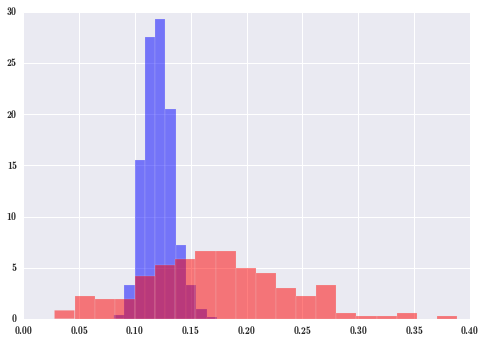

In [254]:
c, b, _ = hist(p.trace(), alpha=0.5, color='b', normed=True)
_ = hist(p_100, bins=20, alpha=0.5, color='r', normed=True)